# Weak Labeling

This notebook generates weak labels for the unlabeled data using k-Nearest Neighbors on sentence embeddings.

In [1]:
import sys
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score

# Add src to path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from data_loader import load_and_split_data
from weak_labeling import WeakLabeler

## Load Data

In [2]:
splits = load_and_split_data()

Loading dataset: descartes100/enhanced-financial-phrasebank (None)
Detected nested dataset structure. Flattening...
Total samples: 4846
Test size: 970
Validation size: 388
Training pool size: 3488
Created split 'train_100': 100 samples
Created split 'unlabeled_100': 3388 samples
Created split 'train_250': 250 samples
Created split 'unlabeled_250': 3238 samples
Created split 'train_500': 500 samples
Created split 'unlabeled_500': 2988 samples
Created split 'train_1000': 1000 samples
Created split 'unlabeled_1000': 2488 samples


## Initialize Weak Labeler

We use `all-mpnet-base-v2` for generating embeddings.

In [3]:
labeler = WeakLabeler(model_name="all-mpnet-base-v2")

## Generate and Evaluate Weak Labels

For each split size, we train a k-NN on the labeled set and predict labels for the unlabeled set. We then compare these weak labels with the true labels (which we have access to for evaluation purposes).

In [4]:
train_sizes = [100, 250, 500, 1000]
results = []

for size in train_sizes:
    print(f"\n=== Weak Labeling for {size} labeled samples ===")
    train_df = splits[f'train_{size}']
    unlabeled_df = splits[f'unlabeled_{size}']
    
    # Train k-NN
    knn = labeler.train_knn(train_df, n_neighbors=5)
    
    # Predict
    weak_labeled_df = labeler.predict(knn, unlabeled_df)
    
    # Evaluate (comparing weak labels to true labels hidden in unlabeled_df)
    # Note: unlabeled_df still has the 'label' column with true labels
    true_labels = unlabeled_df['label']
    predicted_labels = weak_labeled_df['label']
    
    acc = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    
    print(f"Weak Label Quality (Size {size}): Accuracy={acc:.4f}, F1={f1:.4f}")
    
    results.append({
        'train_size': size,
        'weak_accuracy': acc,
        'weak_f1': f1
    })
    
    # Save weak labeled data for next step (optional, or just re-generate)
    # weak_labeled_df.to_csv(f"../data/weak_labeled_{size}.csv", index=False)


=== Weak Labeling for 100 labeled samples ===


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/106 [00:00<?, ?it/s]

Weak Label Quality (Size 100): Accuracy=0.6080, F1=0.6145

=== Weak Labeling for 250 labeled samples ===


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/102 [00:00<?, ?it/s]

Weak Label Quality (Size 250): Accuracy=0.6683, F1=0.6453

=== Weak Labeling for 500 labeled samples ===


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

Weak Label Quality (Size 500): Accuracy=0.6867, F1=0.6717

=== Weak Labeling for 1000 labeled samples ===


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/78 [00:00<?, ?it/s]

Weak Label Quality (Size 1000): Accuracy=0.6901, F1=0.6764


## Plot Weak Label Quality

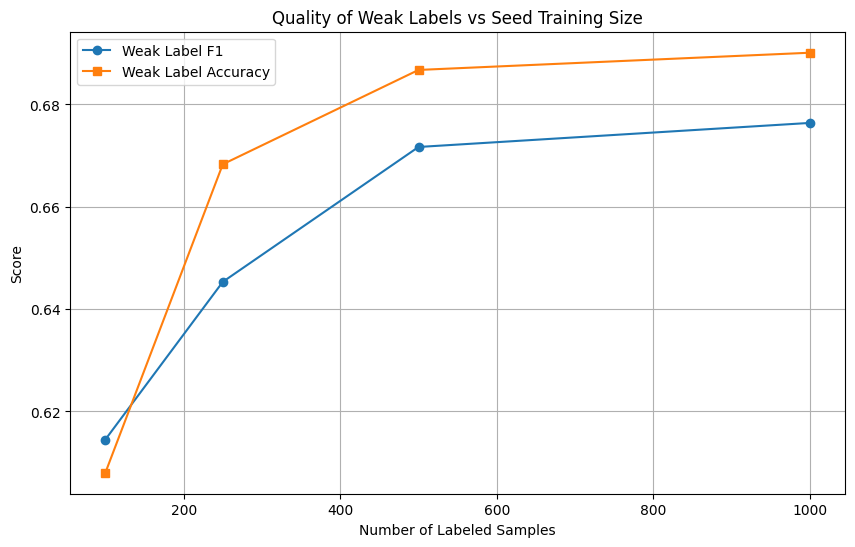

In [5]:
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['train_size'], results_df['weak_f1'], marker='o', label='Weak Label F1')
plt.plot(results_df['train_size'], results_df['weak_accuracy'], marker='s', label='Weak Label Accuracy')
plt.title('Quality of Weak Labels vs Seed Training Size')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()